In [1]:
import sys, os
import numpy as np
from math import *
import math
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
def bb_intersection_over_union(box1, box2):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(box1[0], box2[0])
	yA = max(box1[1], box2[1])
	xB = min(box1[2], box2[2])
	yB = min(box1[3], box2[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
	box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
	iou = interArea / float(box1Area + box2Area - interArea)
	return iou

In [3]:
#HOG
t = 0.5

HOG_precision_score=[]
HOG_recall_score=[]
HOG_false_positive=[]

rect_filename = "/content/drive/MyDrive/paper_face_recognitioin/WIDER-folds/rect/WIDER-fold-rectList.txt"
pred_filename = "/content/drive/MyDrive/paper_face_recognitioin/WIDER-folds/confidence/WIDER-fold-HOG-confidence.txt"
with open(rect_filename) as f:
  rect_lines = [rect_line.rstrip('\n') for rect_line in f]
with open(pred_filename) as p:
  pred_lines = [pred_line.rstrip('\n') for pred_line in p]

confidence = np.linspace(-1,3.5,num=100,endpoint=False)
for c in confidence:
  print("c",c)

  TP=0
  FP=0
  precision_d=0
  recall_d=0

  gt_count = 0
  pred_count = 0
  while gt_count < len(rect_lines):
    gt_num = int(rect_lines[gt_count+1])
    #recall_d
    recall_d += gt_num

    #ground truths bounding boxes of the image
    gt_boxes=[]
    gt_state = np.zeros(gt_num, dtype = int)
    for i in range(gt_num):
      gt_boxes.append([int(g) for g in rect_lines[gt_count+i+2].split(",")])
    gt_box = [list(a) for a in zip(gt_boxes,gt_state)]
    #print(gt_box)

    #predicted boxes of the image
    pred_num = int(pred_lines[pred_count+1])
    pred_boxes = []
    pred_confidence = []
    for j in range(pred_num):
      elements = pred_lines[pred_count+j+2].split("/")
      pred_boxes.append([int(g) for g in elements[0].split(",")])
      pred_confidence.append(float(elements[1]))
    model_box = [list(b) for b in zip(pred_boxes,pred_confidence)]
    #print(model_box)

    for conf in pred_confidence:
      if conf >= c :
        #precision_d
        precision_d += 1

    #IOUs calculated for all predicted boxes with each ground truth bounding box
    if len(model_box) != 0:
      for boxB in model_box:
        if boxB[1] >= c :
          test_iou = []
          for boxA in gt_box:
            box_iou = (bb_intersection_over_union(boxA[0], boxB[0]))
            test_iou.append(box_iou)
        
          if max(test_iou) < t:
            FP += 1
            pass
          elif max(test_iou) >= t :
            max_index = test_iou.index(max(test_iou))
            if gt_box[max_index][1]==0:
              TP += 1
              gt_box[max_index][1]=1
            else:
              FP += 1        

    gt_count = gt_count + gt_num + 2
    pred_count = pred_count + pred_num + 2

  try:
    print("TP",TP)
    print("FP",FP)

    print("precision_d",precision_d)
    precision=TP/precision_d
    print("##precision:",precision)

    print("recall_d",recall_d)
    recall=TP/recall_d
    print("##recall:",recall)
  except:
    precision=0

  HOG_precision_score.append(precision)
  HOG_recall_score.append(recall)
  HOG_false_positive.append(FP)
print(HOG_precision_score)
print(HOG_recall_score)
print(HOG_false_positive)

c -1.0
TP 32094
FP 137654
precision_d 169748
##precision: 0.18906850154346444
recall_d 159447
##recall: 0.20128318500818454
c -0.955
TP 31621
FP 110910
precision_d 142531
##precision: 0.22185349152114278
recall_d 159447
##recall: 0.19831668203227404
c -0.91
TP 31194
FP 88715
precision_d 119909
##precision: 0.2601472783527508
recall_d 159447
##recall: 0.1956386761745282
c -0.865
TP 30759
FP 70666
precision_d 101425
##precision: 0.3032684249445403
recall_d 159447
##recall: 0.19291049690492765
c -0.8200000000000001
TP 30307
FP 56176
precision_d 86483
##precision: 0.35043881456471215
recall_d 159447
##recall: 0.1900756991351358
c -0.775
TP 29834
FP 44591
precision_d 74425
##precision: 0.4008599261001008
recall_d 159447
##recall: 0.18710919615922533
c -0.73
TP 29342
FP 35163
precision_d 64505
##precision: 0.4548794667080071
recall_d 159447
##recall: 0.18402353133015986
c -0.685
TP 28885
FP 27792
precision_d 56677
##precision: 0.5096423593344743
recall_d 159447
##recall: 0.18115737517795882


In [4]:
interpolated_precision = 0
interpolation_range = np.arange(0,1.1,0.1)
for x in range(len(interpolation_range)-1):
  precision_range = []
  for i,r in enumerate(HOG_recall_score):
    if r>=interpolation_range[x] and r<interpolation_range[x+1]:
      precision_range.append(HOG_precision_score[i])
  if precision_range:
    interpolated_precision += max(precision_range)
AUC = interpolated_precision/11
print("AUC",AUC)

AUC 0.19763209109650326


Text(0, 0.5, 'Precision')

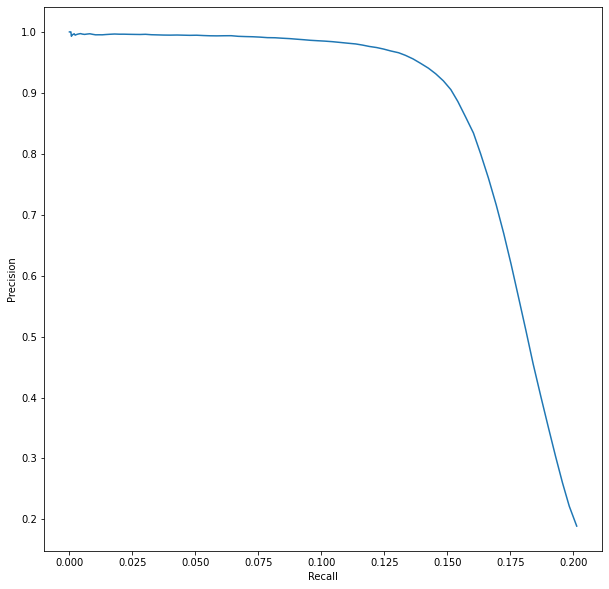

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(HOG_recall_score, HOG_precision_score, label='HOG')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

Text(0, 0.5, 'True Positive Rate')

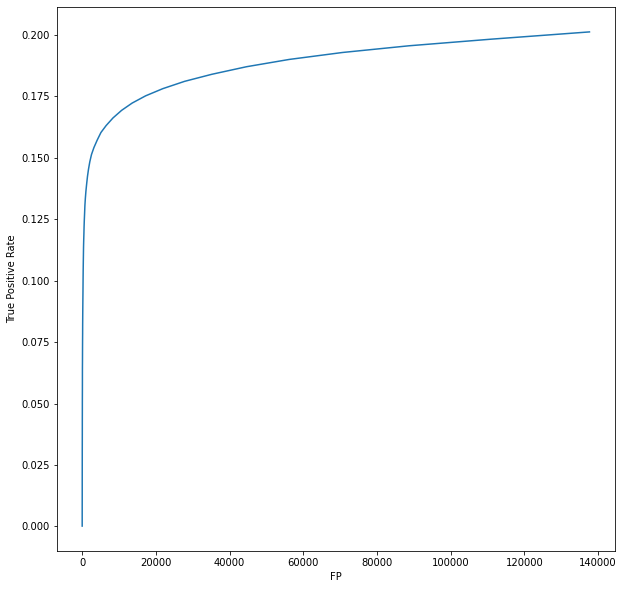

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(HOG_false_positive, HOG_recall_score, label='HOG')
ax.set_xlabel('FP')
ax.set_ylabel('True Positive Rate')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
